# Repeated Edited Nearest Neighbours

Extends Edited Nearest neighbours in that it repeats the procedure over an over, no further observation is removed from the dataset, or alternatively until a maximum number of iterations is reached.

Briefly:

1) Train a KNN algorithm on the entire dataset, typically a 3 KNN

2) Check all observations from majority class and remove observations if its class is different from that of its neighbour

3) Train a new 3 KNN over the remaining observations

4) Go to 2 and repeat.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RepeatedEditedNearestNeighbours

## Create data

We will create data where the classes have different degrees of separateness.

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

In [2]:
def make_data(sep):
    
    # returns arrays
    X, y = make_classification(n_samples=1000,
                           n_features=2,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           weights=[0.99],
                           class_sep=sep,# how separate the classes are
                           random_state=1)
    
    # trasform arrays into pandas df and series
    X = pd.DataFrame(X, columns =['varA', 'varB'])
    y = pd.Series(y)
    
    return X, y

## Repeated Edited Nearest Neighbours

https://imbalanced-learn.org/stable/generated/imblearn.under_sampling.RepeatedEditedNearestNeighbours.html


### Well separated classes

In [3]:
# create data

X, y = make_data(sep=2)

# set up repeated edited nearest neighbour

renn = RepeatedEditedNearestNeighbours(
    sampling_strategy='auto',# removes only the majority class
    n_neighbors=3, # 3 KNN
    kind_sel='all', # all neighbouring observations should show the same class
    n_jobs=4, # 4 processors in my laptop
    max_iter=100) # maximum number of iterations

X_resampled, y_resampled = renn.fit_resample(X, y)

In [4]:
# size of original data

X.shape, y.shape

((1000, 2), (1000,))

In [5]:
# size of undersampled data

X_resampled.shape, y_resampled.shape

((967, 2), (967,))

Compare this output with that of the previous notebook, and see how RENN removes more samples than ENN. This is expected.

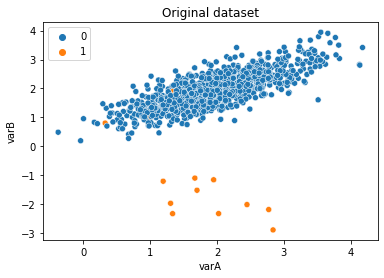

In [6]:
# plot original data

sns.scatterplot(
        data=X, x="varA", y="varB", hue=y
    )

plt.title('Original dataset')
plt.show()

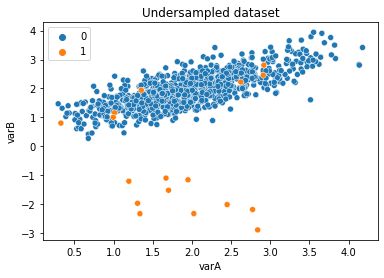

In [7]:
# plot undersampled data

sns.scatterplot(
        data=X_resampled, x="varA", y="varB", hue=y_resampled
    )

plt.title('Undersampled dataset')
plt.show()

Note how some yellow dots can now be seen clearer, as their neighbouring observations from the other class were removed from the data set.

**HOMEWORK**

- change the number of neighbours
- change the max_iter (set it really low)
- compare the distributions and final data set sizes

### Partially separated classes

Let's repeat the same exercise in data where the classes are not so clearly separated. 

In [8]:
# create data
X, y = make_data(sep=0)

# set up repeated edited nearest neighbour transformer

renn = RepeatedEditedNearestNeighbours(
    sampling_strategy='auto',
    n_neighbors=3,
    kind_sel='all',
    n_jobs=4,
    max_iter=100)

X_resampled, y_resampled = renn.fit_resample(X, y)

In [9]:
# original data

X.shape, y.shape

((1000, 2), (1000,))

In [10]:
# undersampled data

X_resampled.shape, y_resampled.shape

((940, 2), (940,))

As the classes are not so clearly distinguished, more samples were removed from the dataset.

Also compare the result from RENN in this notebook, with that of ENN in the previous notebook. You will see that RENN removes more samples from the original dataset.

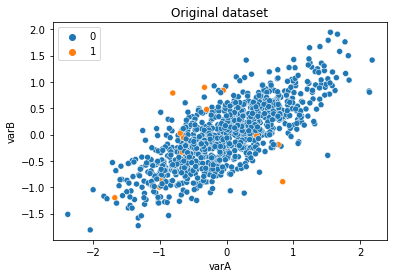

In [11]:
# plot original data

sns.scatterplot(
        data=X, x="varA", y="varB", hue=y
    )

plt.title('Original dataset')
plt.show()

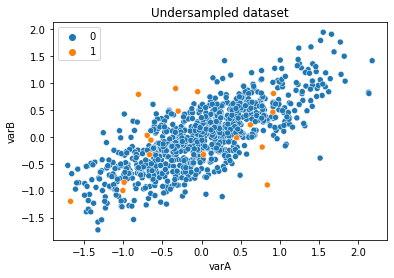

In [12]:
# plot undersampled data

sns.scatterplot(
        data=X_resampled, x="varA", y="varB", hue=y_resampled
    )

plt.title('Undersampled dataset') 
plt.show()

Notice again, that observations have been cleared from the surroundings of those of the minority class.

## Repeated Edited Nearest Neighbours

### Real data - Performance comparison

Does it work well with real datasets? 

Well, it will depend on the dataset, so we need to try and compare the models built on the whole dataset, and that built on the undersampled dataset.

In [13]:
# load data
# only a few observations to speed the computaton

data = pd.read_csv('../kdd2004.csv').sample(10000)

data.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,target
89246,55.50,23.81,-0.51,-42.0,75.0,2256.3,-0.60,1.17,16.5,-73.0,...,2007.5,0.90,0.41,7.0,-78.0,332.2,1.47,0.08,-0.27,-1
134666,83.03,23.81,-1.83,-18.0,6.0,1140.7,0.77,-0.13,3.0,-112.5,...,910.3,-0.05,-1.44,10.0,-65.0,263.2,0.20,-0.26,-1.29,-1
117546,79.03,26.76,-1.72,-3.5,83.0,2786.9,0.14,-0.98,6.0,-81.5,...,3201.4,0.12,1.86,-8.0,-97.0,840.5,1.09,0.33,0.72,-1
54442,83.93,22.34,0.76,29.0,-24.0,590.9,0.74,-0.19,5.5,-52.5,...,996.6,-1.24,0.33,-3.0,-28.0,386.1,-0.44,0.34,-0.19,-1
80001,99.59,22.95,1.82,42.0,-32.0,1954.0,1.14,-0.71,-3.0,-87.0,...,2597.9,-0.60,1.38,-4.0,-88.0,2016.7,-2.65,0.10,0.25,-1


In [14]:
# imbalanced target

data.target.value_counts() / len(data)

-1    0.9914
 1    0.0086
Name: target, dtype: float64

In [15]:
# separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),  # drop the target
    data['target'],  # just the target
    test_size=0.3,
    random_state=0)

In [16]:
# repeated NN

renn = RepeatedEditedNearestNeighbours(
    sampling_strategy='auto',
    n_neighbors=3,
    kind_sel='all',
    n_jobs=4,
    max_iter=100)  # I hve 4 cores in my laptop

X_renn, y_renn = renn.fit_resample(X_train, y_train)

In [17]:
# compare shapes

X_train.shape, X_renn.shape

((7000, 74), (6947, 74))

## Plot data

Let's compare how the data looks before and after the undersampling.

Text(0.5, 1.0, 'Original data')

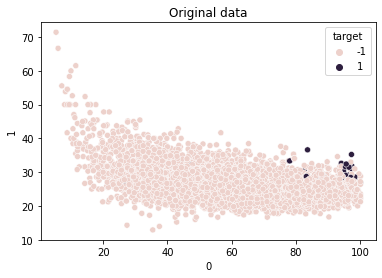

In [18]:
# original data

sns.scatterplot(data=X_train,
                x="0",
                y="1",
                hue=y_train)

plt.title('Original data')

Text(0.5, 1.0, 'Repeated Edited NN data')

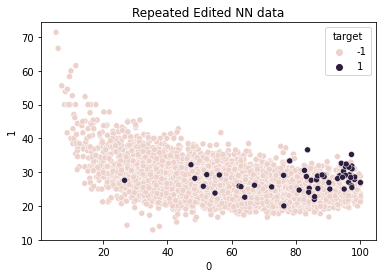

In [19]:
# renn undersampled data

sns.scatterplot(data=X_renn,
                x="0",
                y="1",
                hue=y_renn)

plt.title('Repeated Edited NN data')

Text(0.5, 1.0, 'Original data')

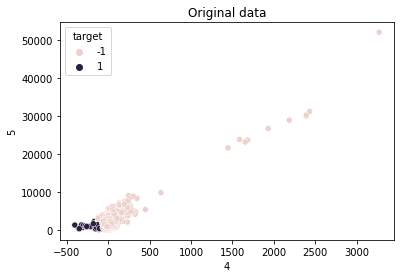

In [20]:
# original data, other set of variables

sns.scatterplot(data=X_train,
                x="4",
                y="5",
                hue=y_train)

plt.title('Original data')

Text(0.5, 1.0, 'Repeated Edited NN data')

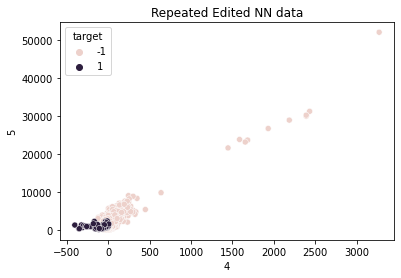

In [21]:
# renn undersampled data

sns.scatterplot(data=X_renn,
                x="4",
                y="5",
                hue=y_renn)

plt.title('Repeated Edited NN data')

## Machine learning performance comparison

Let's compare model performance with and without undersampling.

In [22]:
# function to train random forests and evaluate the performance

def run_randomForests(X_train, X_test, y_train, y_test):
    
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [23]:
# evaluate performance of algorithm built
# using imbalanced dataset

run_randomForests(X_train,
                  X_test,
                  y_train,
                  y_test)

Train set
Random Forests roc-auc: 0.9938102778177631
Test set
Random Forests roc-auc: 0.9711676931090478


In [24]:
# evaluate performance of algorithm built
# using renn undersampled dataset

run_randomForests(X_renn,
                  X_test,
                  y_renn,
                  y_test)

Train set
Random Forests roc-auc: 0.9888883415165497
Test set
Random Forests roc-auc: 0.9673478975804557


Performance seems to improve.

**HOMEWORK**

- Change the number of neighbours and the maximum iteration. Compare the results in terms of data size, distributions and model performance. Change also the selection method from all to mode and evaluate the same aspects.